<a href="https://colab.research.google.com/github/marianadc01/pml-assignments/blob/main/Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mariana Dias Coelho (25605)

Curricular Unit - Practical Machine Learning

MSc in Green Data Science

**Assignment 5**

3 minute video + upload to Moodle

What to do:

- Adapt the Script that implements a neural network with PyTorch (over the iris or mnist datasets) code available in the Overview notebook such that it is implemented with TensorFlow instead of PyTorch.
- Adjust the parameters to try to obtain a global accuracy close to 90% for the MNIST dataset.

**Original code from ML_overview_with_examples**

Epoch [100/500], Train Loss: 0.1438, Test Loss: 0.0960
Epoch [200/500], Train Loss: 0.0580, Test Loss: 0.1763
Epoch [300/500], Train Loss: 0.0755, Test Loss: 0.1063
Epoch [400/500], Train Loss: 0.1513, Test Loss: 0.1077
Epoch [500/500], Train Loss: 0.1371, Test Loss: 0.0702


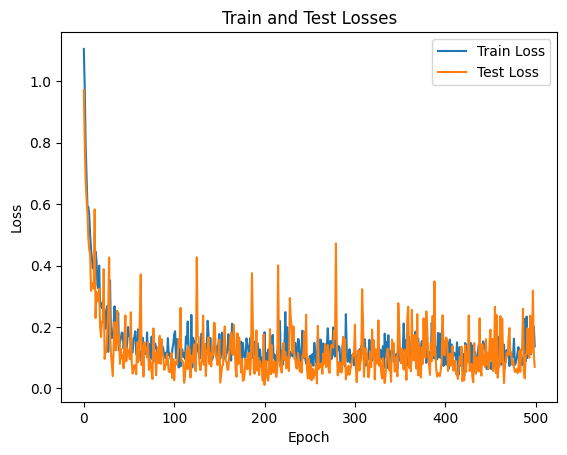

Accuracy on test set: 1.0000


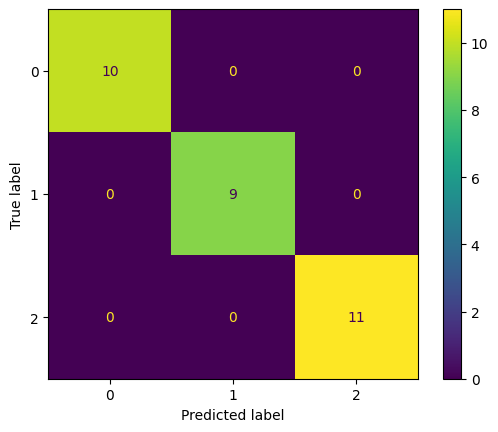

In [1]:
#@title Script that implements a neural network with PyTorch (over the iris or mnist datasets)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random
import numpy as np

CREATE_CLASS=True # Create class from scratch; otherwise use nn.Sequential to create the class
SGD=False # SGD or Adam
IRIS=True # iris or mnist
SHOW=False # returns picture of digit for mnist

# Load Iris dataset
if IRIS:
    examples = load_iris()
else:
    examples = load_digits() # https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html; 10 digits;  1797 examples
    if SHOW:
        idx=random.randint(0,len(examples.target))
        print(examples.data[idx])
        print(examples.data[idx].reshape(8,8))
        print(examples.target[idx])
        plt.matshow(examples.data[idx].reshape(8,8), cmap=plt.cm.gray_r)
        plt.show()

X = examples.data
y = examples.target

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Instantiate the model
input_size = X_train_tensor.shape[1]
hidden_size = 8
output_size = len(examples.target_names)
batch_size=120
num_epochs = 500
# Optimizer specific options
learning_rate=0.1
regularization_param=0.001
momentum_param=0.9
# Dropout: if p>0
dropout_p=0.25 # During training, randomly zeroes some of the elements of the input tensor with probability p.

# Create dataloader which makes it easier to use mini batches
train_dl=DataLoader(TensorDataset(X_train_tensor,y_train_tensor), batch_size, shuffle=True)

########################################################### NN model
if CREATE_CLASS:
    # Create model, first defining the class with a forward method
    class ThreeLayerNet(nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
            super(ThreeLayerNet, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size)
            self.fc2 = nn.Linear(hidden_size, hidden_size)
            self.fc3 = nn.Linear(hidden_size, output_size)
            self.dropout = nn.Dropout(p=dropout_p)  # Dropout layer with dropout probability
        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = self.dropout(x)  # Apply dropout after first hidden layer
            x = torch.relu(self.fc2(x))
            x = self.dropout(x)  # Apply dropout after second hidden layer
            x = self.fc3(x)
            return x
    model = ThreeLayerNet(input_size, hidden_size, output_size)
else:
    # Or, in alternative, use nn.Sequential
    model=nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Dropout(p=dropout_p),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Dropout(p=dropout_p),
        nn.Linear(hidden_size, output_size)
    )
####################################################################################################
# Define loss function and optimizer
# Either torch.nn.NLLLoss or torch.nn.CrossEntropyLoss can be used: CrossEntropyLoss (https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) implements softmax internally
criterion = nn.CrossEntropyLoss() #
# Optimizer: optimizer object that will hold the current state and will update the parameters based on the computed gradients
# for param in model.parameters(): print(param.data)
if SGD:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=regularization_param, momentum=momentum_param)
else:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=regularization_param)

# Lists to store train and test losses
train_losses = []
test_losses = []

# Training the model
for epoch in range(num_epochs):
    train_loss = 0.0
    for x_batch, y_batch in train_dl:
        # Forward pass
        pred = model(x_batch) # Returns tensor: nrows=tensor batch_size; ncols=number of classes
        loss = criterion(pred, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad() # Resets the gradients of all optimized tensors
        loss.backward() # Computes gradient
        optimizer.step() # Performs a single optimization step (parameter update).

        train_loss += loss.item() # .item() extracts the scalar value of the loss tensor

    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    # Test the model
    with torch.no_grad():
        outputs = model(X_test_tensor)
        test_loss = criterion(outputs, y_test_tensor)
        test_losses.append(test_loss.item())

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# Plotting train and test losses
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Losses')
plt.legend()
plt.show()

# Testing the model
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1) # Returns a namedtuple (values, indices) where values is the maximum value of each row of the input tensor in the given dimension dim. And indices is the index location of each maximum value found (argmax).

actual=y_test_tensor.numpy()
pred=predicted.numpy()
accuracy = accuracy_score(actual, pred)
print(f'Accuracy on test set: {accuracy:.4f}')
cm=confusion_matrix(actual, pred)
labels = np.unique(actual)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()

**New code for the assignment**

[ 0.  1.  8. 13. 16. 13.  0.  0.  0.  1. 13. 12. 15. 16.  0.  0.  0.  0.
  0.  5. 15.  8.  0.  0.  0.  0.  5. 15.  5.  0.  0.  0.  0.  0.  6. 16.
 11.  1.  0.  0.  0.  0.  2. 13. 16. 11.  0.  0.  0.  0.  0.  2. 14. 16.
  4.  0.  0.  0. 13. 16. 15.  7.  0.  0.]
[[ 0.  1.  8. 13. 16. 13.  0.  0.]
 [ 0.  1. 13. 12. 15. 16.  0.  0.]
 [ 0.  0.  0.  5. 15.  8.  0.  0.]
 [ 0.  0.  5. 15.  5.  0.  0.  0.]
 [ 0.  0.  6. 16. 11.  1.  0.  0.]
 [ 0.  0.  2. 13. 16. 11.  0.  0.]
 [ 0.  0.  0.  2. 14. 16.  4.  0.]
 [ 0.  0. 13. 16. 15.  7.  0.  0.]]
3


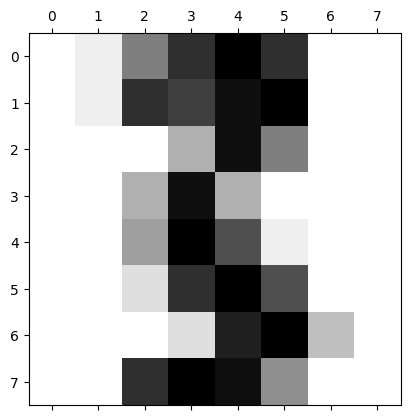

Epoch 1/50
21/21 [==============================] - 2s 21ms/step - loss: 1.8278 - accuracy: 0.4609 - val_loss: 1.1334 - val_accuracy: 0.8472
Epoch 2/50
21/21 [==============================] - 0s 14ms/step - loss: 0.9150 - accuracy: 0.7997 - val_loss: 0.5182 - val_accuracy: 0.9097
Epoch 3/50
21/21 [==============================] - 0s 13ms/step - loss: 0.4726 - accuracy: 0.8886 - val_loss: 0.3159 - val_accuracy: 0.9236
Epoch 4/50
21/21 [==============================] - 0s 7ms/step - loss: 0.3121 - accuracy: 0.9188 - val_loss: 0.2247 - val_accuracy: 0.9236
Epoch 5/50
21/21 [==============================] - 0s 13ms/step - loss: 0.2211 - accuracy: 0.9435 - val_loss: 0.1749 - val_accuracy: 0.9444
Epoch 6/50
21/21 [==============================] - 0s 12ms/step - loss: 0.1705 - accuracy: 0.9567 - val_loss: 0.1647 - val_accuracy: 0.9444
Epoch 7/50
21/21 [==============================] - 0s 15ms/step - loss: 0.1466 - accuracy: 0.9637 - val_loss: 0.1517 - val_accuracy: 0.9444
Epoch 8/50
21/

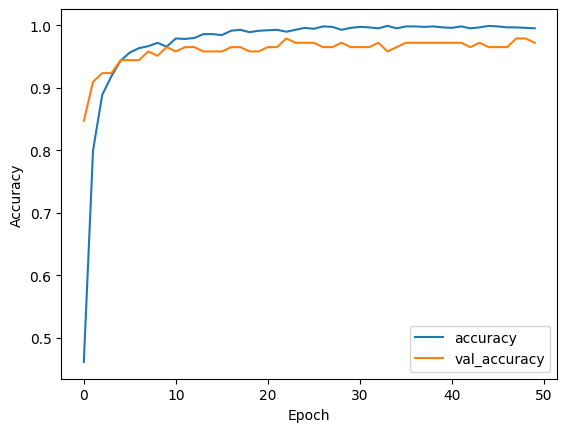

Test accuracy: 0.9778
12/12 [==============================] - 0s 2ms/step


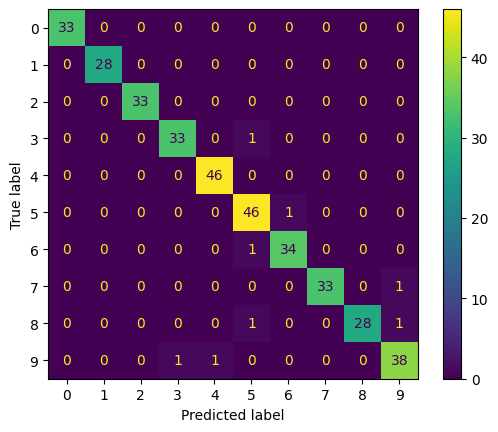

In [6]:
import tensorflow as tf
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

CREATE_CLASS=True # Create class from scratch; otherwise use nn.Sequential to create the class
SGD=False # SGD or Adam
IRIS=False # iris or mnist
SHOW=True # returns picture of digit for mnist

# Load Iris dataset
if IRIS:
    examples = load_iris()
else:
    examples = load_digits() # https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html; 10 digits;  1797 examples
    if SHOW:
        idx=random.randint(0,len(examples.target))
        print(examples.data[idx])
        print(examples.data[idx].reshape(8,8))
        print(examples.target[idx])
        plt.matshow(examples.data[idx].reshape(8,8), cmap=plt.cm.gray_r)
        plt.show()

X = examples.data
y = examples.target

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert numpy arrays to TensorFlow tensors
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.int32)

# Instantiate the model
input_size = X_train_tensor.shape[1]
hidden_size = 128
output_size = 10
batch_size = 64
num_epochs = 50

# Optimizer specific options
learning_rate = 0.001
dropout_rate = 0.2

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_size, activation='relu', input_shape=(input_size,)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(hidden_size, activation='relu'),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(output_size, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_tensor, y_train_tensor, epochs=num_epochs, batch_size=batch_size, validation_split=0.1)

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_tensor, y_test_tensor, verbose=0)
print(f'Test accuracy: {test_accuracy:.4f}')

# Confusion matrix
y_pred = np.argmax(model.predict(X_test_tensor), axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot()
plt.show()


**Changes made to the code:**

- Changed the library: imported TensorFlow instead of PyTorch;

- Dataset: There's still the option to load the Iris dataset but since the second point focused on the MNIST dataset, we defined it as False;

- Model Definition:
  - Replaced the PyTorch model definition with a TensorFlow Sequential model using tf.keras.Sequential.
  - Defined the model layers using tf.keras.layers.Dense for fully connected layers and tf.keras.layers.Dropout for dropout layers.
  - Added ReLU activation function for hidden layers and softmax activation for the output layer.
  - Used input_shape parameter in the first layer to specify the input shape.

- Model Compilation:
  - Compiled the model using model.compile() method.
  - Specified the loss function (sparse_categorical_crossentropy) and evaluation metric (accuracy).

- Training Loop:
  - Replaced the training loop with model.fit(), passing training data, batch size, number of epochs, and validation split directly.
  - Removed manual optimization steps (zero gradients, backward pass, optimizer step) as TensorFlow's fit() method handles these internally.

- Evaluation:
  - Evaluated the model using model.evaluate() method, passing the test data.
  - Used verbose=0 to suppress output during evaluation.